In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import json
import plotly.express as px
import plotly
from shapely import geometry, ops
from shapely.geometry import LineString, MultiLineString
from enum import Enum

In [2]:
# https://arakaki.tokyo/20210919/
def reduce_lines(gdf, to, name):    
    class Direction(Enum):
        FORWARD = 0
        BACKWARD = 1   

    def list_to_gdf(l):
        gdf = gpd.GeoDataFrame({"geometry": [LineString(l)]})
        return gdf
        
    def list_to_df(l):        
        df = pd.DataFrame(l, columns=['lon', 'lat'])
        df['group'] = f'{name}_{group_count}'
        return df
    
    def line_to_tuple(iterable, list_of_tuple):
        for i in iterable:
            if isinstance(i, LineString):
                list_of_tuple.append(tuple(i.coords))
            elif isinstance(i, MultiLineString): 
                line_to_tuple(i, list_of_tuple)
            
    if to == "pandas":
        list_to = list_to_df
    elif to == "geopandas":
        list_to = list_to_gdf
    else:
        raise TypeError("'to' argument must be 'pandas' or 'geopandas'")

    work = list()
    dfs = list()
    lines = list()
    line_to_tuple(gdf.geometry, lines)
    
    lines = list(set(lines))
    
    dir = Direction.BACKWARD
    group_count = 1
    
    
    while lines:
        if not work:
            work.extend(lines.pop(0))
            continue
        
        if dir == Direction.BACKWARD:
            for i, line in enumerate(lines):
                if work[-1] in line:
                    l = list(lines.pop(i))
                    if l[0] != work[-1]:
                         l.reverse()
                    work.extend(l[1:])
                    break
            else:
                dir = Direction.FORWARD
                continue
        else:
            for i, line in enumerate(lines):
                if work[0] in line:
                    l = list(lines.pop(i))
                    if l[-1] != work[0]:
                        l.reverse()
                    work[0:0] = l[:-1]
                    break
            else:
                dfs.append(list_to(work))
                group_count += 1
                work = list()
                dir = Direction.BACKWARD
    
    if work:
        dfs.append(list_to(work))
        
    all = pd.concat(dfs)
    
    if to == "geopandas":
        all = all.dissolve()
    else:
        all.reset_index(drop=True, inplace=True)
        
    all["name"] = name
    return all


def convert_all(gdf, to):
    all = list()
    for name in gdf.name.unique():
        all.append(reduce_lines(gdf.query(f'name.str.startswith("{name}")', engine='python'), to, name))

    all_df = pd.concat(all)
    all_df.reset_index(drop=True, inplace=True)
    return all_df

In [3]:
def df_for_plotly(geo_df):
    lats = []
    lons = []
    names = []

    for feature, name in zip(geo_df.geometry, geo_df.name):
        if isinstance(feature, geometry.linestring.LineString):
            linestrings = [feature]
        elif isinstance(feature, geometry.multilinestring.MultiLineString):
            linestrings = feature.geoms
        else:
            continue
        for linestring in linestrings:
            x, y = linestring.xy
            lats = np.append(lats, y)
            lons = np.append(lons, x)
            names = np.append(names, [name]*len(y))
            lats = np.append(lats, None)
            lons = np.append(lons, None)
            names = np.append(names, None)
    
    return pd.DataFrame({"lat": lats, "lon": lons, "name": names})

,N06_012,N06_013,N06_014,N06_015,N06_016,N06_017,N06_018,N06_019,geometry
0,2015,2015,9999,EA03_513042,None,None,南相馬鹿島SIC,2,POINT (140.91992 37.71533)
1,2015,2015,9999,EA03_524062,None,None,高岡砺波SIC,2,POINT (137.00071 36.65548)
2,2015,2015,9999,EA03_521021,None,None,南砺SIC,2,POINT (136.90220 36.60014)
3,2015,2015,9999,EA03_517015,None,None,府中SIC,2,POINT (139.49477 35.66003)
4,2015,2015,9999,EA03_543043,None,None,豊前,1,POINT (131.12569 33.58766)
...,...,...,...,...,...,...,...,...,...
2383,2020,2020,9999,EA03_872001,None,None,田野畑北,1,POINT (141.83938 39.94355)
2384,2020,2020,9999,EA03_872002,None,None,普代,1,POINT (141.88767 40.00381)
2385,2020,2020,9999,EA03_847004,None,None,馬場,1,POINT (139.64122 35.50678)
2386,2020,2020,9999,EA03_826006,None,None,常盤,1,POINT (135.51549 34.58963)


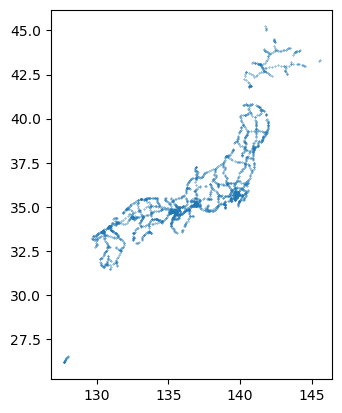

In [4]:
df_ic = gpd.read_file("data/N06-20/N06-20_Joint.geojson")
df_ic.plot(markersize=0.1)
df_ic

In [5]:
gdf_way = gpd.read_file("data/N06-20/N06-20_HighwaySection.geojson").iloc[:, [6,7,8,9,11]]
gdf_way.columns = ["name", "路線種別", "供用状況", "車線数", "geometry"]
gdf_way = gdf_way.sort_values('name').drop_duplicates(subset="geometry").reset_index(drop=True)
# sorted_gdf = gdf_way.groupby("name")#.apply(sort_linestring).reset_index()
# sorted_gdf.drop(["name", "level_1"], axis=1, inplace=True)
# sorted_gdf = sorted_gdf.merge(gdf_way, on="geometry")
gdf_way.drop(900, inplace=True)
# gdf_way = gdf_way[gdf_way["name"]=="名阪国道"]
gdf_way

,name,路線種別,供用状況,車線数,geometry
0,みちのく有料道路,2,2,2,"LINESTRING (140.86717 40.82480, 140.86771 40.8..."
1,七尾氷見道路,3,2,2,"LINESTRING (136.95509 36.85655, 136.95587 36.8..."
2,七尾氷見道路,3,2,2,"LINESTRING (136.98546 37.02235, 136.98333 37.0..."
3,七尾氷見道路,3,2,2,"LINESTRING (136.97098 36.87695, 136.97311 36.8..."
4,七尾氷見道路,3,1,2,"LINESTRING (137.04810 36.97198, 137.04750 36.9..."
...,...,...,...,...,...
1250,鷹巣西道路,2,1,2,"LINESTRING (140.37316 40.19870, 140.37133 40.1..."
1251,鹿児島道路,3,2,2,"LINESTRING (130.41111 31.61944, 130.41017 31.6..."
1252,鹿児島道路,3,2,2,"LINESTRING (130.50740 31.59171, 130.50726 31.5..."
1253,鹿児島道路,3,2,2,"LINESTRING (130.51525 31.58596, 130.51445 31.5..."


In [6]:
gdf_way = gdf_way[gdf_way["name"]=="名阪国道"]
df_way = convert_all(gdf_way, "pandas")
df_way

,lon,lat,group,name
0,136.414075,34.858583,名阪国道_1,名阪国道
1,136.414893,34.857061,名阪国道_1,名阪国道
2,136.415271,34.856399,名阪国道_1,名阪国道
3,136.415823,34.855473,名阪国道_1,名阪国道
4,136.416234,34.854677,名阪国道_1,名阪国道
...,...,...,...,...
996,135.836105,34.617552,名阪国道_1,名阪国道
997,135.835335,34.617622,名阪国道_1,名阪国道
998,135.834101,34.617634,名阪国道_1,名阪国道
999,135.833117,34.617622,名阪国道_1,名阪国道


In [7]:
fig = px.line_mapbox(
    df_way,
    lat="lat",
    lon="lon",
    color="name",
    line_group="group",
    mapbox_style="carto-darkmatter",
    hover_data={"group":False},
    zoom=3.8
)

fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

In [8]:
# df = gpd.read_file("data/japan-motorway.json")
# a = df.dropna(subset="name").iloc[:,[1,2,-1]]
# a.to_pickle("data/japan-motorway.pkl")

df = gpd.GeoDataFrame(pd.read_pickle("data/japan-motorway.pkl"))
df = df[df["name"].str.contains("名阪")]
df = convert_all(df, "pandas")
df

,lon,lat,group,name
0,135.832036,34.617559,名阪国道_1,名阪国道
1,135.834667,34.617631,名阪国道_1,名阪国道
2,135.835128,34.617634,名阪国道_1,名阪国道
3,135.835585,34.617625,名阪国道_1,名阪国道
4,135.836037,34.617602,名阪国道_1,名阪国道
...,...,...,...,...
4948,136.416985,34.853608,名阪国道 (無料区間)_1,名阪国道 (無料区間)
4949,136.417053,34.853392,名阪国道 (無料区間)_1,名阪国道 (無料区間)
4950,136.417107,34.853183,名阪国道 (無料区間)_1,名阪国道 (無料区間)
4951,136.417139,34.852984,名阪国道 (無料区間)_1,名阪国道 (無料区間)


In [9]:
fig = px.line_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="name",
    line_group="group",
    mapbox_style="carto-darkmatter",
    hover_data={"group":False},
    zoom=5
)

fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

In [ ]:
# "https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N06-v1_2.html
# https://arakaki.tokyo/20210919/
# https://plotly.com/python-api-reference/generated/plotly.express.line_mapbox.html?highlight=line_map
# https://mapped.newman.me/example-plotly-lines.html"